# Acquire data from accelerometer from DAQ Board
## Callin Switzer
## 5/3/2016
## Update 7/16/2016
## Update 8/18/2016
## Update 15 March 2017
## 23 May 2017 Started trials with hive 7 & 8 from Koppert

# 5/26 new SSD update

Preparing for no-reward experiments

Download nidaq driver for ni USB-6229 (save to thumb drive)

Download/update anaconda

download PyDAQmx

download pySerial

# Setup

In [1]:
# setup arduino
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PyDAQmx import * #works -- need to install NiDACmx (takes like a day to download)

In [3]:
import datetime

import flycapture2 as fc2 # works

In [4]:
import serial # works

In [5]:
import cv2
print cv2.__version__


3.2.0


In [6]:
import time

import os
import peakutils 
import msvcrt
import winsound
import shutil
import pandas as pd

In [7]:
 % qtconsole

In [8]:
PORT1 = "COM3"
connected1 = False
ser1 = serial.Serial(PORT1,9600)
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print "connected to arduino on COM3" 

connected to arduino on COM3


In [9]:
# define function for recording and rewarding buzzes
def recRew(ftestMin, ftestMax, trt):
     
        
    aThr = [0,5]
    
    # loop to look for specific frequencies
    fmin = 5.0
    fmax = 520.0

    counterAlarm = 50

    peakFrq = np.array(0)
    pwr = np.array(0)
    pwrCutoff = 0.004 # lower amplitude cutoff
    sleepTime = 0 # seconds

    # make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
    # 100000 samples is one second
    # Note: to get higher resolution for peak freq, I'd need a larger window
    N_samples = 20000 
    log_rate = 200000.0

    ctr = 0
    ctr2 = 0
    
    # start buzz timer
    buzzTime = time.time()
    
    # open text file
    with open(str(outDir)+ '_ampFreq.txt', 'a') as text_file:  

        # clear characters waiting to be read
        while msvcrt.kbhit():
            msvcrt.getch()
            print 'clearing characters ...'

        while ctr <= (2*counterAlarm - 1): # only give a max of 100 buzzes
                
            taskHandle = TaskHandle()
            read = int32()
            data = np.zeros((N_samples,), dtype=np.float64)

            DAQmxCreateTask("", byref(taskHandle))
            # I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
            DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                                     "Accelerometer", DAQmx_Val_Diff, 
                                     -10.0, 10.0, DAQmx_Val_Volts, None)
            DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                                  DAQmx_Val_Rising, 
                                  DAQmx_Val_FiniteSamps, N_samples)

            DAQmxStartTask(taskHandle)
            DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                               DAQmx_Val_GroupByChannel, data, 
                               N_samples, byref(read), None)

            if taskHandle:
                DAQmxStopTask(taskHandle);
                DAQmxClearTask(taskHandle);

            # 20fft
            n =len(data) # length of the signal
            k = np.arange(n, step = 1)
            T = n/log_rate
            frq = k/T # two sides frequency range
            frq = frq[range(n/2)] # one side frequency range

            Y = np.fft.fft(data)/n # fft computing and normalization
            Y = Y[range(n/2)]

            # calculate top frequency
            ind = np.argpartition(abs(Y), -4)[-4:]
            # Find highest point on the spectrum
            peakFrq = frq[ind[::-1]]
            pwr = (abs(Y)[ind[::-1]])
            domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

            beeFrqPwr = pwr[peakFrq == domPK]
            # print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

            # if the bee is vibrating at a high enough power and the dominant peak from the 
            # vibration is in the right range
            if beeFrqPwr > pwrCutoff and domPK > fmin and domPK < fmax:
                buzzTime = time.time()
                
                reward = 'F'

                aamp = np.max(data) - np.min(data)
                # write value to serial port, and get it to start the turn on the motor
                s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
                print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))

                                
                # take a photo and save it
                im = fc2.Image()
                c.retrieve_buffer(im)
                a = np.array(im)
                cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + s3 + '.pgm', a) # .pgm / ppm is quite fast, and can be read by imageJ
                
                
                #print reward number
                print('Counter Number ' + str(ctr))
                
                # reward only give pollen at specific frequencies and ampliude threshold
                if domPK > ftestMin and domPK < ftestMax and (aThr[0] < aamp < aThr[1]):
                                    
                    ctr = ctr + 1
                    
                    if (trt == 1) and (ctr <= counterAlarm):
                        written = ser1.write("20")
                        reward = 'T'
                        
                    if (trt == 2) and (ctr > counterAlarm):
                        written = ser1.write("20")
                        reward = 'T'

                    # beep for end of program
                    if ctr > counterAlarm - 5:
                        for i in range(counterAlarm - ctr):
                            winsound.Beep(400,100)

                    if ctr > counterAlarm:
                        for i in range(counterAlarm - ctr):
                            winsound.Beep(400,500)

                ############################### PLOT ##################################
                # create subplot 1
                ax1 = plt.subplot(211)
                ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
                ax1.set_ylabel("Volts")
                ax1.set_xlabel("time (s)")
                if reward == 'T':
                    ax1.set_facecolor('grey')

                # create subplot 2
                ax2 = plt.subplot(212)
                ax2.plot(frq,abs(Y),'r')
                ax2.plot(domPK, beeFrqPwr, 'ro')
                ax2.set_xlim(20, 1000)
                ax2.set_ylabel('power')
                ax2.set_xlabel('frequency')
                plt.tight_layout()
                plt.show()


                #################### SAVE FILE FROM ACCEL ##############################
                np.savetxt((os.getcwd() + '\\' + outDir + '\\' + s3 + '_' + str(ftestMin) + '_' + 
                           str(ftestMax) + '_' + str(aThr[0]) + '_' +  str(aThr[1]) + '.txt'), 
                           (np.array(range(len(data)))/ float(log_rate), data), delimiter = ' ')

                ### write frequency and amplitude to file
                var1 = (str(domPK) + ', ' + 
                           str(round(np.max(data) - np.min(data), 5)) + ', ' + 
                           s3 + ', ' + str(ctr) +', ' + str(reward) + 
                        ',' + str(aThr[0]) + 
                        ',' + str(aThr[1]) + '\n')
                text_file.writelines(var1)

                # sleep
                time.sleep(sleepTime)
            
            else:
                #take a photo every 5 loops
                # take a photo and save it
                if ctr2 % 5 == 0:
                    s4 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
                    im = fc2.Image()
                    c.retrieve_buffer(im)
                    a = np.array(im)
                    cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + s4 + "_bkg" + '.pgm', a) # .pgm / ppm is quite fast, and can be read by imageJ

                ctr2 += 1
            

            # break loop if someone presses the 'q' while in terminal
            if msvcrt.kbhit():
                if msvcrt.getch() == 'q':
                    # disconnect camera 
                    c.stop_capture()
                    c.disconnect()
                    print 'keyboard q pressed, now quitting loop'
                    for i in range(5):
                        winsound.Beep(450,100)
                    break   
                else:
                    written = ser1.write("20")
            
           # print(time.time() - buzzTime)
            
            # if bee goes for 5 minutes without buzzing, end the loop
            if time.time() - buzzTime > (5.0 * 60):
                # disconnect camera 
                c.stop_capture()
                c.disconnect()
                print 'Bee Stopped buzzing, now quitting loop'
                for i in range(5):
                    winsound.Beep(450,100)
                break   
                    
            ## move file to new folder at end of loop!

    # make sound when loop stops
    for i in range(3):
        winsound.Beep(350,500)

new directory created: 2017_05_31__14_24_49
the current python direcory is C:\Users\Combes4\Desktop\Temp
2
2017_05_31__14_25_31_245 topFreq = 90.0 amp = 0.0580847137861
Counter Number 0


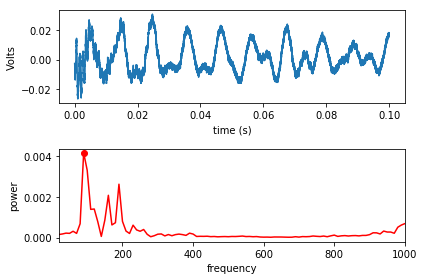

2017_05_31__14_25_48_283 topFreq = 100.0 amp = 0.169386707483
Counter Number 0


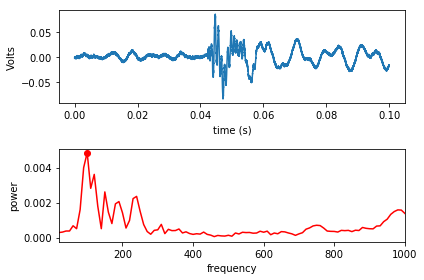

keyboard q pressed, now quitting loop


In [56]:
## reward amplitudes
rewAAmp = "test" # test rewards at any amplitude and freq's between 220 and 450

# change python directory to Dropbox
os.chdir('C:\Users\Combes4\Desktop\Temp')
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())
                                                                                                                 
# make new file
open(str(outDir)+ '_ampFreq.txt', 'a').close()

# start camera -- point grey Chameleon
c = fc2.Context()
c.connect(*c.get_camera_from_index(0))
c.start_capture()

# capture a background image (may be useful for image subtraction)
im = fc2.Image()
c.retrieve_buffer(im)
a = np.array(im)
cv2.imwrite(os.getcwd() + '\\' + outDir + '\\' + 'background.pgm', a) 

# change treatment each trial (randomly)
ttrt = int(np.random.choice([1,2], size = 1))
print ttrt

recRew(trt =ttrt, ftestMin=220, ftestMax =450)

In [55]:
## make new folder and move files into that folder
hhive = '7'
ddate = (datetime.datetime.now().strftime("%Y_%m_%d"))

if 'bn' in globals():
    bn += 1
else:
    bn = 237

BeeNum = str(bn)



if (ttrt == 2):
    treatment = "RewSec"
elif (ttrt == 1):
    treatment = "RewFir"

finFolder = 'B_' + BeeNum + '_' + ddate + '_H_'+  hhive + '_' + treatment

# make new folder if it doesn't exist
if not os.path.isdir(os.getcwd() + '\\' + finFolder):
    os.mkdir(os.getcwd() + '\\' + finFolder)
    
    # move files into new folder
    #os.rename(os.getcwd() + '\\' + outDir, os.getcwd() + '\\' + outDir +'\\' + finFolder)
    os.rename(os.getcwd() + '\\' + outDir + '_ampFreq.txt', os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt')
    
    # move folder to new folder
    src = os.getcwd() + '\\' + outDir
    dst = os.getcwd() + '\\'  + finFolder + '\\'+ outDir
    shutil.move(src, dst)
    
else: 
    print 'directory already exists'


    
# calculate mean frequency (only for rewarded buzzes)
ff = os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt'
dd = pd.read_csv(ff, header = None)

print "beeNum " + str(bn)

dd2 = dd[(dd.ix[:,0] > 220) & (dd.ix[:,0] < 450)]


print "total rewards"
print np.sum(np.array(dd2.ix[:,4]) == " T")

# print "total buzzes"
# print len(dd2)

print "mean Freq rewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])

print "total buzzes not rewarded"
print np.sum(np.array(dd2.ix[:,4]) == " F")

print "mean Freq Unrewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"])

# save metadata to file
metadataFile = (datetime.datetime.now().strftime("%Y_%m_%d")) + '_metadata.csv'

# make new file if it doesn't exist (with header)
if not os.path.isfile(metadataFile):
    with open(metadataFile, 'a') as the_file:
        the_file.write('timeOfTrial,beeNum,treatment,folder,totalRewards,meanFreqRewarded,totalBuzzesNotRewarded,meanFreqUnrewarded')
        the_file.write('\n')
else: 
    print 'file already exists -- adding to file'

# now write data to file                       
with open(metadataFile, 'a') as the_file:
    the_file.write(outDir + ',' + str(bn) + ','+
                   treatment + ',' + 
                   finFolder + ',' + 
                   str(np.sum(np.array(dd2.ix[:,4]) == " T")) + ',' + 
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])) + ',' + 
                  str(np.sum(np.array(dd2.ix[:,4]) == " F")) + ',' +
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"]))
                  )
    the_file.write('\n')                 


beeNum 254
total rewards
50
mean Freq rewarded
314.0
total buzzes not rewarded
22
mean Freq Unrewarded
321.363636364
file already exists -- adding to file


In [ ]:
# calculate mean frequency (only for rewarded buzzes)
ff = os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt'
dd = pd.read_csv(ff, header = None)

print "beeNum " + str(bn)

dd2 = dd[(dd.ix[:,0] > 220) & (dd.ix[:,0] < 450)]


print "total rewards"
print np.sum(np.array(dd2.ix[:,4]) == " T")

# print "total buzzes"
# print len(dd2)

print "mean Freq rewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])

print "total buzzes not rewarded"
print np.sum(np.array(dd2.ix[:,4]) == " F")

print "mean Freq Unrewarded"
print np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"])

# save metadata to file
metadataFile = (datetime.datetime.now().strftime("%Y_%m_%d")) + '_metadata.csv'

# make new file if it doesn't exist (with header)
if not os.path.isfile(metadataFile):
    with open(metadataFile, 'a') as the_file:
        the_file.write('timeOfTrial,beeNum,treatment,folder,totalRewards,meanFreqRewarded,totalBuzzesNotRewarded,meanFreqUnrewarded')
        the_file.write('\n')
else: 
    print 'file already exists -- adding to file'

# now write data to file                       
with open(metadataFile, 'a') as the_file:
    the_file.write(outDir + ',' + str(bn) + ','+
                   treatment + ',' + 
                   finFolder + ',' + 
                   str(np.sum(np.array(dd2.ix[:,4]) == " T")) + ',' + 
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " T"])) + ',' + 
                  str(np.sum(np.array(dd2.ix[:,4]) == " F")) + ',' +
                  str(np.mean(dd2.ix[:,0][dd2.ix[:,4] == " F"]))
                  )
    the_file.write('\n')                 


In [ ]:
print "total rewards"
np.sum(np.array(dd2.ix[:,4]) == " T")

In [ ]:
print "total buzzes"
len(dd2)

In [ ]:
plt.hist(np.array(dd2.ix[:,0]), bins = 20)

In [ ]:
np.array(dd2.ix[:,0])

In [ ]:
# get file list in directory
fllist = os.listdir(os.getcwd() + '//' + outDir)

fpth = [os.getcwd() + '//' + outDir + '//' + ii for ii in fllist]    

sust = [os.access(kk, os.W_OK) for kk in fpth]

print "num read only files = " + str( np.sum(not sust))


In [ ]:
print fc2.get_library_version()
c = fc2.Context()
print c
print c.get_num_of_cameras()

In [ ]:
import shutil

In [ ]:
src = os.getcwd() + '\\' + outDir
dst = os.getcwd() + '\\'  + finFolder + '\\'+ outDir
shutil.move(src, dst)

In [ ]:
os.getcwd() + '\\' + outDir

In [ ]:
# make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
# 100000 samples is one second
# Note: to get higher resolution for peak freq, I'd need a larger window
N_samples = 20000 
log_rate = 200000.0

ctr = 0


taskHandle = TaskHandle()
read = int32()
data = np.zeros((N_samples,), dtype=np.float64)

DAQmxCreateTask("", byref(taskHandle))
# I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                         "Accelerometer", DAQmx_Val_Diff, 
                         -10.0, 10.0, DAQmx_Val_Volts, None)
DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                      DAQmx_Val_Rising, 
                      DAQmx_Val_FiniteSamps, N_samples)

DAQmxStartTask(taskHandle)
DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                   DAQmx_Val_GroupByChannel, data, 
                   N_samples, byref(read), None)

if taskHandle:
    DAQmxStopTask(taskHandle);
    DAQmxClearTask(taskHandle);

# fft
n = len(data) # length of the signal
k = np.arange(n)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(data)/n # fft computing and normalization
Y = Y[range(n/2)]

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]
# print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

# if the bee is vibrating at a high enough power and the dominant peak from the 
# vibration is in the right range

reward = 'F'

aamp = np.max(data) - np.min(data)
# write value to serial port, and get it to start the turn on the motor
s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))

# reward only give pollen at specific frequencies and ampliude threshold
############################### PLOT ##################################
# create subplot 1
ax1 = plt.subplot(211)
ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
ax1.set_ylabel("Volts")
ax1.set_xlabel("time (s)")
if reward == 'T':
    ax1.set_facecolor('grey')

# create subplot 2
ax2 = plt.subplot(212)
ax2.plot(frq,abs(Y),'r')
ax2.plot(domPK, beeFrqPwr, 'ro')
ax2.set_xlim(20, 1000)
ax2.set_ylabel('power')
ax2.set_xlabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
data

In [ ]:
# fft
n = len(data) # length of the signal
k = np.arange(n)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(data)/n # fft computing and normalization

In [ ]:
Y = Y[range(n/2)]

In [ ]:
ps = np.abs(np.fft.fft(data))**2

time_step = 1/100000000.0
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

ax2 = plt.subplot(212)
ax2.plot(freqs[idx] / 1000, ps[idx],'r')
ax2.set_xlim(420, 450)

In [ ]:
freqs

In [ ]:
# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

In [ ]:
Y

In [ ]:
# change python directory to desktop
os.chdir('C:\\Users\\Combes4\\Desktop\\')
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())

# make new file
open(str(outDir)+ '_ampFreq.txt', 'a').close()

In [ ]:
# change python directory to desktop
os.chdir('C:\\Users\\Combes4\\Desktop\\')                    
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())


## alternative, increasing amplitude version

# loop to look for specific frequencies
fmin =5
fmax = 450

ftestMin = 220
ftestMax = 450

ampThresh = 0.0

counterAlarm = 30

peakFrq = np.array(0)
pwr = np.array(0)
pwrCutoff = 0.004
sleepTime = 0 # seconds

# make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
# 100000 samples is one second
# Note: to get higher resolution for peak freq, I'd need a larger window
N_samples = 10000 
log_rate = 100000.0

ctr = 0

# open text file
with open(str(outDir)+ '_ampFreq.txt', 'a') as text_file:  

    # clear characters waiting to be read
    while msvcrt.kbhit():
        msvcrt.getch()
        print 'clearing characters ...'

    while True:
        taskHandle = TaskHandle()
        read = int32()
        data = np.zeros((N_samples,), dtype=np.float64)

        DAQmxCreateTask("", byref(taskHandle))
        # I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
        DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                                 "Accelerometer", DAQmx_Val_Diff, 
                                 -10.0, 10.0, DAQmx_Val_Volts, None)
        DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                              DAQmx_Val_Rising, 
                              DAQmx_Val_FiniteSamps, N_samples)

        DAQmxStartTask(taskHandle)
        DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                           DAQmx_Val_GroupByChannel, data, 
                           N_samples, byref(read), None)

        if taskHandle:
            DAQmxStopTask(taskHandle);
            DAQmxClearTask(taskHandle);

        # fft
        n = len(data) # length of the signal
        k = np.arange(n)
        T = n/log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(n/2)] # one side frequency range

        Y = np.fft.fft(data)/n # fft computing and normalization
        Y = Y[range(n/2)]

        # calculate top frequency
        ind = np.argpartition(abs(Y), -4)[-4:]
        # Find highest point on the spectrum
        peakFrq = frq[ind[::-1]]
        pwr = (abs(Y)[ind[::-1]])
        domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

        beeFrqPwr = pwr[peakFrq == domPK]
        # print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

        # if the bee is vibrating at a high enough power and the dominant peak from the 
        # vibration is in the right range
        if beeFrqPwr > pwrCutoff and domPK > fmin and domPK < fmax:
            reward = 'F'
            
            aamp = np.max(data) - np.min(data)
            # write value to serial port, and get it to start the turn on the motor
            s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
            print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))
            
            # reward only give pollen at specific frequencies and ampliude threshold
            if domPK > ftestMin and domPK < ftestMax and aamp > ampThresh:
                written = ser1.write("20")
                ctr = ctr + 1
                print('reward ' + str(ctr))
                reward = 'T'
                ampThresh = ampThresh + 0.02
                
                # beep for end of program
                if ctr > counterAlarm - 5:
                    for i in range(counterAlarm - ctr):
                        winsound.Beep(400,100)

                if ctr > counterAlarm:
                    for i in range(counterAlarm - ctr):
                        winsound.Beep(400,500)

            ############################### PLOT ##################################
            # create subplot 1
            ax1 = plt.subplot(211)
            ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
            ax1.set_ylabel("Volts")
            ax1.set_xlabel("time (s)")

            # create subplot 2
            ax2 = plt.subplot(212)
            ax2.plot(frq,abs(Y),'r')
            ax2.plot(domPK, beeFrqPwr, 'ro')
            ax2.set_xlim(20, 1000)
            ax2.set_ylabel('power')
            ax2.set_xlabel('frequency')
            plt.tight_layout()
            plt.show()


            #################### SAVE FILE FROM ACCEL ##############################
            np.savetxt(os.getcwd() + '\\' + outDir + '\\' + s3+ '_' + str(ftestMin) + '_' + str(ftestMax) + '.txt', 
                       (np.array(range(len(data)))/ float(log_rate), data), delimiter = ' ')

            ### write frequency and amplitude to file on desktop
            var1 = str(domPK) + ', ' + str(round(np.max(data) - np.min(data), 5)) + ', ' + s3 + ', ' + str(ctr) +', ' + str(reward) + ', '+ str(ampThresh) + '\n'
            text_file.writelines(var1)

            # sleep
            time.sleep(sleepTime)
            
           

        # break loop if someone presses the 'q' while in terminal
        if msvcrt.kbhit():
            if msvcrt.getch() == 'q':
                print 'keyboard q pressed, now quitting loop'
                for i in range(5):
                    winsound.Beep(450,100)
                break   
            else:
                written = ser1.write("20")


In [ ]:
import random

In [ ]:
random.sample(np.arange(1,5),4)